In [3]:
"""A generic module for things that don't yet fit in better elsewhere. As we build a codebase,
we will refactor into more specific modules."""
import os
os.chdir("astro530")


FileNotFoundError: [Errno 2] No such file or directory: 'astro530'

In [4]:
import numpy as np
import constants as sc
import scipy.special as special
import math_tools as mtools
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from scipy.interpolate import griddata

In [5]:
def planck(v, T):
    """
    Name: 
        planck
    
    Purpose:
        Return the Planck function for a given temperature and wavenumber.
    
    Explanation: 
        Gives the blackbody intensity for a given temperature and wavenumber (inverse wavelength, in micrometers)
    
    Calling Seuqence:
        planck, v, T, B
        
    Input/Output:
        v - The wavenumber, in inverse micrometers (scalar or array)
        T - The temperature of the blackbody, in degrees Kelvin (scalar)
        B - The blackbody intensity returned (for each v)
    
    Limitations:
        Will throw divide by zero warning for wavenumber zero. 
        
    Notes
        Model formula:
        .. math:: B_\\nu = \\frac{2 h \\vu^3}{c^2}\\frac{1}{e^{h\\nu/kT}-1}
    
    """
    freq = sc.c * v[:, np.newaxis] * 1e4
    B =  (2 * sc.h * freq**3 / sc.c**2) * (1/(np.exp(sc.h * freq/(sc.k * T))-1))
    return B

In [6]:
def h_nu_zero(snu, nu = None, nsteps = 1000, xmin = 3e-7, xmax = 1e2):
    """
    Name: 
        h_nu_plus
    
    Purpose:
        Return the first moment of the intensity.
    
    Explanation: 
        Gives the first moment of the intensity, which is the flux dividid by 4*pi
    
    Calling Seuqence:
        H_nu_zero, snu, nsteps, xmax
        
    Input/Output:
        snu - the source function 
        nsteps - number of grid points
        xmax - maximum for integral
        
    
    """
    if nu is None:
        integrand = lambda x: snu(x) * special.expn(2, x)
        h_nu = 0.5 * mtools.integral(integrand, xmin, xmax, nsteps)
    else:
        h_nu = np.zeros(len(nu))
        for idx, n in enumerate(nu):
            integrand = lambda x: snu(x, n) * special.expn(2, x)
            h_nu[idx] = 0.5 * mtools.integral(integrand, xmin, xmax, nsteps)
        
    return h_nu

In [7]:
def h_nu(snu, nu, tau, nsteps = 250, xmin = 3e-7, xmax = 1e2):
    """
    Name: 
        h_nu_tau
    
    Purpose:
        Return the first moment of the intensity, at arbitrary optical depth
    
    Explanation: 
        Gives the first moment of the intensity, which is the flux dividid by 4*pi
    
    Calling Seuqence:
        H_nu, snu, nsteps, xmax
        
    Input/Output:
        snu - the source function 
        nsteps - number of grid points
        xmax - maximum for integral
        
    
    """
    if nu is None:
        integrand = lambda x: snu(x) * special.expn(2, x)
        h_nu = 0.5 * mtools.integral(integrand, xmin, xmax, nsteps)
    else:
        h_nu = np.zeros(len(nu))
        for idx, n in enumerate(nu):
            integrandu = lambda x: snu(x, n) * special.expn(2, (x - tau))
            integrandd = lambda x: snu(x, n) * special.expn(2, (tau - x))
            h_nu[idx] = 0.5 * mtools.integral(integrandu, tau + xmin, xmax, nsteps) + 0.5 * mtools.integral(integrandd, tau - xmin, xmin, nsteps)
        
    return h_nu

In [8]:
def h_nu_eb(snu, nsteps = 250):
    integrand = lambda x: snu(x) * x
    h_nu = 0.5 * mtools.integral(integrand, 0, 1, nsteps, logspace = False)
    return h_nu

In [9]:
def greyT(Teff, tau):
    """
    Name: 
        greyT
    
    Purpose:
        Return the temeprature as a function of optical depth in the grey, LTE, first Eddington
        case.
    
    Explanation: 
        T= Teff * (3/4(tau + 2/3))^1/4
    
    
        
    Input/Output:
        Teff - The effective temp
        tau - scalar optical depth at which to evaluate 
        T - the returned temperature 
        
    
    """
    return Teff * (3/4*(tau +2/3)) **(1/4)

In [10]:
def partition(species, T):
    """
    Name: 
        partition
    
    Purpose:
        Return the partition function for a specified temperature
    
    Explanation: 
        The values are given at 5040/T in the range of 0.2 to 2.0, stepping by 0.2
    
    
    
    """
    with open('partit.csv', mode='r') as infile:
        reader = csv.reader(infile, delimiter = ' ')
        dat = {rows[0]: [10**float(a) if a != '-' else float("nan") for a in rows[1:-1]]for rows in reader}
    degreesPerIndex = 5040*2/10
    if np.ndim(T) > 0:
        partit = np.zeros(len(T))
        for n, t in enumerate(T):
            #ie the temperature in units of array index
            degreesInIndex = (t - 0.2*5040)/degreesPerIndex 
            lowerIndex = int(np.floor(degreesInIndex))
            if (lowerIndex < 0) or (lowerIndex + 1 > 10):
                partit[n] = float("nan")
            else:
                partit[n] = (dat[species][lowerIndex+1] - dat[species][lowerIndex]) * \
                (degreesInIndex - lowerIndex) + dat[species][lowerIndex]
    else:
        degreesInIndex = (T - 0.2*5040)/degreesPerIndex 
        lowerIndex = int(np.floor(degreesInIndex))
        if (lowerIndex < 0) or (lowerIndex + 1 > 10):
            partit = float("nan")
        else:
            partit = (dat[species][lowerIndex+1] - dat[species][lowerIndex]) * \
            (degreesInIndex - lowerIndex) + dat[species][lowerIndex]
    return partit

In [11]:
def phi(species, T):
    """
    Name: 
        phi
    
    Purpose:
        Return the ratio of singly ionized to unionized. 
    """
    with open('ioniz.csv', mode='r') as infile:
        reader = csv.reader(infile, delimiter = ' ', skipinitialspace = True)
        dat = {rows[1]: [float(a) for a in rows[3:]] for rows in reader}
    partitionLow = partition(species, T)
    if species == "H-":
        partitionHigh = partition("H", T)
    else:
        partitionHigh = partition(species + "+", T)
    return 1.2020e9 * partitionHigh/partitionLow * (5040/T)**(-5/2) * 10**(-5040 * dat[species][0]/T)

In [12]:
def kHminusBF(Pe, T, v):
    """
    Name:
        kHminusBF
        
    Purpose: Returns the H- bound free opacity for a given pressure, temperature, and wavenumber
    """
    coeffs = np.array([1.99654, -1.18267e-5, 2.64243e-6, -4.40524e-10, 3.23992e-14, -1.39568e-18, 2.78701e-23])
    lambd = 1e4/v
    theta = 5040/T
    alphabf = sum(np.array([1, lambd, lambd**2, lambd**3, lambd**4, lambd**5, lambd**6]) * coeffs)
    return 4.158e-10 * 1e-18 * alphabf * Pe * theta**(5/2) * 10**(0.754*theta)

In [13]:
def kHminusFF(Pe, T, v):
    """
    Name:
        kHminusFF
        
    Purpose: Returns the H- free free opacity for a given pressure, temperature, and wavenumber
    """
    lambd = 1e4/v
    theta = 5040/T
    x = np.log10(lambd)
    f0 = -2.2763 - 1.685 * x + 0.76661 * x**2 - 0.053346 * x**3
    f1 = 15.2827 - 9.2846 * x + 1.99381 * x**2 - 0.142631 * x**3
    f2 = -197.789 + 190.266 * x - 67.9775 * x**2 + 10.6913 * x**3 - 0.625151 * x**4
    return 1e-26 * Pe * 10**(f0 + f1 * np.log10(theta) + f2 * np.log10(theta)**2)

In [14]:
def gbf(lambd, n):
    R = 1.0968e-3
    return 1 - (0.3456/(lambd * R)**(1/3) ) * ((lambd * R)/n**2 - 1/2)

In [15]:
def gff(lambd, T):
    R = 1.0968e-3
    theta = 5040/T
    chi = 1.2398e4/lambd
    return 1 + (0.3456/(lambd * R)**(1/3) ) * ((np.log10(np.e))/(theta * chi) + 1/2)

In [16]:
def kHBF(T, v):
    """
    Name:
        kHBF
        
    Purpose: Returns the H bound free opacity for a given pressure, temperature, and wavenumber
    """
    lambd = 1e4/v
    theta = 5040/T
    n0 = np.zeros(len(v))
    for i, l in enumerate(lambd):
        if l < 912:
            n0[i] = 1
        elif l >= 912 and l <= 3746:
            n0[i] = 2
        elif l > 3746 and l <= 8206:
            n0[i] = 3   
        elif l > 8206 and l <= 14588:
            n0[i] = 4
        else:
            n0[i] = 5    
    chi = lambda n: 13.6 * (1 - 1/n**2)
    chi3 = 13.6 * ( 1 - (1/(n0 + 3)**2))
    ns = [n0, n0+1, n0+2]
    term1 = sum([gbf(lambd, n)/n**3 * 10**(-theta * chi(n)) for n in ns])
    term2 = np.log10(np.e)/(2 * theta * 13.6) * (10**(-chi3 * theta) - 10**(-13.6 *theta))
    return 1.0449e-26 *lambd**3 * (term1+term2)
    

In [17]:
def kHFF(T, v):
    """
    Name:
        kHFF
        
    Purpose: Returns the neutral hydrogen free free opacity for a given temperature, and wavenumber
    """
    lambd = 1e4/v
    theta = 5040/T
    return 1.0449e-26 * lambd**3 * gff(lambd, T) * np.log10(np.e)/(2*theta*13.6) * 10**(-theta * 13.6)

In [18]:
def ke(T, Pe, Pg, abundances):
    return 0.6648e-24 * Pe/(Pg - Pe) * sum(abundances)

In [19]:
def kTot(T, Pe, v):
    lambd = 1e4/v
    chi = 1.2398e4/lambd
    theta = 5040/T
    phifactor = 1/(1 + phi("H", T)/Pe)
    return ((kHBF(T, v) + kHFF(T, v) + kHminusBF(Pe, T, v)) * (1 - 10**(-chi * theta)) + kHminusFF(Pe, T, v)) * phifactor

In [20]:
def Pe(T, Pg, dat = None):
    #atomic	element	weight	A	logA	logA12
    abundances = []
    if np.ndim(T) == 0:
        T = np.array([T])
    if dat is None:
        with open('SolarAbundance.txt', mode='r') as infile:
            reader = csv.reader(infile, delimiter = '\t')
            dat = {rows[1]: [float(a) if a != '' else 0 for a in rows[2:-1]] for rows in reader}   
    sahas = []
    abundances = []
    for species in dat.keys():
        myPhi = phi(species, T)
        myPhi = [k if not math.isnan(k) else 0 for k in myPhi]
        sahas.append(myPhi)
        abundances.append(dat[species][1] )
    sahas = np.array(sahas)
    abundances = np.array(abundances)
    Pes = np.array([Pg/2 if temp > 9000 else Pg**0.5 for temp in T])
    #print(np.shape(np.array(sahas)), abundances)
    n = 0
    PeOld = np.zeros(len(Pes))
    while True in np.greater(np.abs((Pes - PeOld))/Pes, .001):
        PeOld = Pes
        n+= 1
        #print(n)
        #print(np.shape(abundances), np.shape(sahas), np.shape(PeOld))
        numerator =  (sahas[:] / PeOld) / (1 + sahas[:]/PeOld)
        denominator =  ( 1 + numerator)
        Pes = Pg * sum(abundances[:, np.newaxis] * numerator)/sum(abundances[:, np.newaxis] * denominator)
    #print(numerator, Pes, PeOld)
    return Pes

In [21]:
def hjerting(u, a):
    return np.real(special.wofz(u + 1j * a))

In [51]:
class valiic:
    def __init__(self):
        self.valiic = pd.read_csv('VALIIIC_sci_e.txt', delimiter = ' ', skipinitialspace = True)
        self.tau = interp1d(self.valiic['h'], self.valiic['tau_500'], kind = 'cubic')
        self.T = interp1d(self.valiic['h'], self.valiic['T'], kind = 'cubic')
        self.nh = interp1d(self.valiic['h'], self.valiic['n_H'], kind = 'cubic')
        self.ne = interp1d(self.valiic['h'], self.valiic['n_e'], kind = 'cubic')
        self.ptot = interp1d(self.valiic['h'], self.valiic['Ptotal'], kind = 'cubic')
        self.pgas = interp1d(self.valiic['h'], self.valiic['Pgas/Ptotal']*self.valiic['Ptotal'], kind = 'cubic')
        self.v = interp1d(self.valiic['h'], self.valiic['V'], kind = 'cubic')
        self.rho = interp1d(self.valiic['h'], self.valiic['rho'])
        self.source = None
        
        with open('SolarAbundance.txt', mode='r') as infile:
            reader = csv.reader(infile, delimiter = '\t')
            self.abundances = {rows[1]: [float(a) if a != '' else 0 for a in rows[2:-1]] for rows in reader}   
        #the abundacnes
        self.justAbs = []
        #the masses
        self.ms = []
        
        #Line opacity params
        self.gammaN =  (1e8 * 6.16e-1 + 1e8*6.14e-1)
        self.lineDat = {'NaD1': [5896, -15.33, 1e8 * 6.14e-1, 2, 2], 
                        'NaD2' : [5890, -15.17, 1e8 * 6.16e-1, 4, 2]}
        
        for key in self.abundances.keys():
            self.justAbs.append(self.abundances[key][1])
            self.ms.append(self.abundances[key][0])
        self.justAbs = np.array(self.justAbs)
        self.ms = np.array(self.ms)
    
    def numP(self, h):
        #Using N1/N0 Pe = Phi(T)
        myPe = self.ne(h) * sc.k * self.T(h)
        h2h1 = phi('H', self.T(h))/myPe
        hp = self.nh(h) / (1 + 1/h2h1)
        return hp
    
    def neCont(self, species, h):
        #the number of e- from the species we're looking at
        myPe = self.valiicPe(h)
        n2n1 = phi(species, self.T(h))/myPe
        #multiply the abundance by the ionization fraction by the number of H
        return  (n2n1 / (1 + n2n1)) * self.abundances[species][1] * self.nh(h) / (myPe / (sc.k * self.T(h)))
    
    def valiicPe(self, h):
        if np.ndim(h) == 0:
            h = np.array([h])
        abundances = []  
        sahas = []
        abundances = self.justAbs
        T = self.T(h)
        Pg = self.pgas(h)
        for species in self.abundances.keys():
            myPhi = phi(species, T)
            myPhi = [k if not math.isnan(k) else 0 for k in myPhi]
            sahas.append(myPhi)
        sahas = np.array(sahas)
        abundances = np.array(abundances)
        Pes = np.array([Pg[i]/2 if temp > 9000 else Pg[i]**0.5 for i, temp in enumerate(T)])
        #print(np.shape(np.array(sahas)), abundances)
        n = 0
        PeOld = np.zeros(len(Pes))
        #print(Pes)
        while True in np.greater(np.abs((Pes - PeOld))/Pes, .001):
            PeOld = Pes
            n+= 1
            #print(n)
            #print(np.shape(abundances), np.shape(sahas), np.shape(PeOld))
            numerator =  (sahas / PeOld) / (1 + sahas/PeOld)
            denominator =  ( 1 + numerator)
            Pes = Pg * sum(abundances[:, np.newaxis] * numerator)/sum(abundances[:, np.newaxis] * denominator)
        #print(numerator, Pes, PeOld)
        return Pes        

    def kTot(self, h, v, Pe = None):
        if np.ndim(h) == 0:
            h = np.array([h])
        if np.ndim(v) == 0:
            v = np.array([v])
        Ts = self.T(h)
        if Pe is None:
            Pe = self.valiicPe(h)
        Pg = self.pgas(h)
        #Pg = np.array([1.14e5])
        lambd = 1e4/v
        chi = 1.2398e4/lambd
        theta = 5040/Ts
        n2n1 = phi("H", self.T(h))/Pe
        phifactor = 1/(1 + phi("H", Ts)/Pe)
        #print(kHBF(Ts[0],v))
        initial = [(((kHBF(T, v) + kHFF(T, v) + kHminusBF(Pe[i], T, v)) * (1 - 10**(-chi * theta[i])) +
                    kHminusFF(Pe[i], T, v)) * phifactor[i] + ke(T, Pe[i], Pg[i], self.justAbs)) for i, T in enumerate(Ts)]
        #print(initial)
        w = (sum(self.ms*self.justAbs))*1.6605e-24
        #return [phifactor, initial/(sum(self.ms*self.justAbs))/1.6605e-24, Pe, Pg, [[ke(T, Pe[i], Pg[i], self.justAbs)/w, (1 - 10**(-chi * theta[i])), kHBF(T, v)/w* phifactor[i], kHFF(T, v)/w* phifactor[i], kHminusBF(Pe[i], T, v)/w* phifactor[i],kHminusFF(Pe[i], T, v)/w* phifactor[i]] for i, T in enumerate(Ts)]]
        return np.transpose(initial/(sum(self.ms*self.justAbs))/1.6605e-24)
    
    def g4(self, h, line):
        Pe = self.valiicPe(h)
        #Pe = self.ne(h) *self.T(h) * sc.k
        T = self.T(h)
        return 10**(19 + 2/3 * self.lineDat[line][1] + np.log10(Pe) - 5/6 * np.log10(T))
    
    def g6(self, h, line):
        lambd = self.lineDat[line][0]
        I = 5.1391
        x = 1.2398e4/lambd
        C6 = .3e-30 * (1/(I - x)**2 - 1/(I)**2)
        return 10**(20 + 0.4 * np.log10(C6) + np.log10(self.pgas(h)) - 0.7 * np.log10(self.T(h)))
        
    def sigTherm(self, h, line):
        lambd = self.lineDat[line][0]
        dl = 4.301e-7 * lambd * (self.T(h) / 22.9898)**0.5
        return dl / 2**0.5
    
    def sigMic(self, h, line):
        lambd = self.lineDat[line][0]
        dl = lambd * self.v(h)/ (sc.c /1e5)
        return dl / 2**0.5
    
    def sigTot(self, h, line):
        
        return np.sqrt(self.sigMic(h, line)**2 + self.sigTherm(h, line)**2)

    
    def linea(self, h, v, line):
        lambd = 1e4/v
        l0 = self.lineDat[line][0]
        gamma = self.g6(h, line) + self.g4(h, line) + self.gammaN
        sigma = self.sigTot(h, line)
        x = lambd - l0
        f = 1.884e-15 * l0**2 * self.lineDat[line][3]/self.lineDat[line][4] * self.lineDat[line][2] / (4 * np.pi)
        prefactor = 4.995e-21 * l0**2/ (sigma* 2**0.5) * f
        u = x[:, np.newaxis]/(sigma * 2**0.5) 
        a = 1* gamma / (4 * np.pi) * l0**2/(sc.c* 1e8) / (sigma * 2**0.5)
       
        return prefactor * hjerting(u, a)
    
    def lineK(self, h, v, line, Pe = None):
        T = self.T(h)
        if Pe is None:
            Pe = self.valiicPe(h)
        lambd = 1e4/v[:, np.newaxis]
        chi = 1.2398e4/lambd
        theta = 5040/T
        nGround= 2/partition('Na', T)
        #the fraction of sodium capable of absorbing
        nNe = 1/ (1 + phi('Na', T)/Pe) * nGround
        #now the number abundance of Na times Nh/rho
        rhoNh = self.abundances['Na'][1] / (sum(self.ms*self.justAbs) * 1.6605e-24)
        kv = nGround * nNe * rhoNh * (1 - 10**(-chi * theta)) * self.linea(h, v, line) 
        #print((1 - 10**(-chi * theta)))
        return kv
    
    def tauTot(self, h, v):
        h = sorted(h, reverse = True)
        hEvals = [self.valiic['h'][18]]
        idx = []
        #print(h)
        #print(hEvals)
        for height in h:
            #print(height, hEvals)
            increment = min( hEvals[-1]- height, 10)
            newHs = np.arange(height, hEvals[-1],  increment)
            #print(newHs)
            idx.append(len(newHs))
            hEvals.extend(newHs[::-1])
            #print(hEvals, newHs)
        hEvals = np.array(hEvals)
        T = self.T(hEvals[1:])
        #print(T)
        Pe = self.ne(hEvals[1:]) * sc.k * T
        rho = self.rho(hEvals[1:])
        dl = (hEvals[1:] - hEvals[:-1]) * 1e5
        kCont = self.kTot(hEvals[1:], v, Pe)
        kLine = self.lineK(hEvals[1:], v, 'NaD1', Pe) + self.lineK(hEvals[1:], v, 'NaD2', Pe)
        #print(np.shape(kCont), np.shape(kLine))
        integral =  np.cumsum((kCont + kLine) * rho * dl, axis = 1)
        #return np.shape(integral)
        #print(integral)
        return  -(integral[:, np.cumsum(idx)-1])
    
    def sourceFunction(self, v, nh = 2000):
        hvals = np.logspace(np.log10(2176), 0, nh) - 76
        
        hvals = np.linspace(2176, 1, nh) - 76
        taus = self.tauTot(hvals, v)
        T = self.T(hvals)
        Bvals = planck(v, T)
        return (taus, Bvals)
    
    def h_nu_zero(self, v, nh = 2000):
        grid = self.sourceFunction(v, nh)
        taus = grid[0][:][:]
        Bvs = grid[1][:][:]
        dt = np.diff(taus)
        return np.sum(Bvs[:, 1:] * special.expn(2, taus)[:,1:] * dt, axis = -1)
        
   
        

In [52]:
c = valiic()
#(c.linea(np.array([20, 20, 30]), np.array([1e4/5800, 1e4/5890]), 'NaD1'))
#c.tauTot(np.array([20, 10, 0]),np.array([1e4/5896]))

In [49]:
hs = np.linspace(2000, -75, 30)
freqs = np.linspace(1e4/5886, 1e4/5900, 1000)
y = c.sourceFunction(freqs)

ValueError: A value in x_new is below the interpolation range.

In [53]:
(flux - c.h_nu_zero(freqs, nh = 2000))/flux

array([0.01492437, 0.01492282, 0.01492126, 0.01491969, 0.0149181 ,
       0.01491649, 0.01491486, 0.01491322, 0.01491157, 0.01490989,
       0.0149082 , 0.01490649, 0.01490476, 0.01490302, 0.01490125,
       0.01489947, 0.01489767, 0.01489585, 0.01489401, 0.01489215,
       0.01489027, 0.01488837, 0.01488645, 0.01488451, 0.01488255,
       0.01488056, 0.01487856, 0.01487653, 0.01487448, 0.01487241,
       0.01487031, 0.01486819, 0.01486605, 0.01486388, 0.01486169,
       0.01485947, 0.01485723, 0.01485496, 0.01485267, 0.01485035,
       0.014848  , 0.01484562, 0.01484322, 0.01484079, 0.01483833,
       0.01483584, 0.01483332, 0.01483077, 0.01482819, 0.01482558,
       0.01482293, 0.01482026, 0.01481755, 0.01481481, 0.01481203,
       0.01480922, 0.01480638, 0.0148035 , 0.01480058, 0.01479763,
       0.01479464, 0.01479161, 0.01478855, 0.01478544, 0.01478229,
       0.01477911, 0.01477588, 0.01477261, 0.01476929, 0.01476593,
       0.01476253, 0.01475909, 0.01475559, 0.01475205, 0.01474

In [37]:
flux = c.h_nu_zero(freqs)

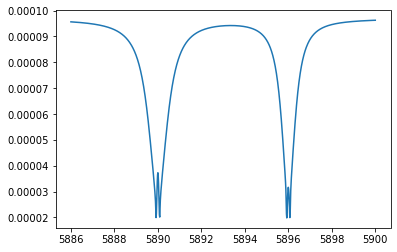

In [38]:
plt.plot(1e4/freqs, 2*np.pi *flux)

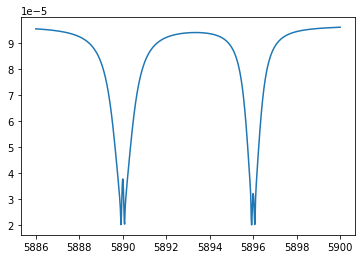

In [832]:
plt.plot(1e4/freqs, 2*np.pi *flux)

In [652]:
planck(np.array([1e4/5000]), np.array([6220]))

array([[3.14265469e-05]])

In [556]:
planck(np.array([1e4/5005, 1e4/3000]), np.array([1e4, 2e4, 3e4])).flatten()

array([0.00018952, 0.00098732, 0.00197179, 0.0001226 , 0.00147133,
       0.00372866])

In [31]:
c.tauTot(np.array([1950, 1900]), np.array([1e4/5890, 1e4/5896]))

array([[6.10320326e-07, 9.43702963e-07],
       [5.22585308e-07, 7.69421095e-07]])

In [774]:
hs = np.linspace(2000, -75, 30)
freqs = np.linspace(1e4/5886, 1e4/5900, 1000)
tauConty = c.tauTot(hs, freqs)

In [622]:
planck(np.array([1e4/5000]), np.array([5180]))

array([[1.23401474e-05]])

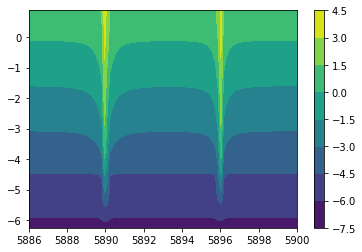

In [401]:
fig, ax = plt.subplots()
cs = ax.contourf(1e4/freqs, np.log10(c.tau(hs)), np.transpose(np.log10(tauConty)))
cbar = fig.colorbar(cs)

In [372]:
min(c.valiic['h'][c.valiic['h'] >= 20])
np.log10(9e3)

3.9542425094393248

In [238]:
(c.lineK(np.array([0, 5, 10]), np.array([1e4/5900, 1e4/5896]), 'NaD1'))

[0.03732265 0.03700519 0.03670047]


array([[4.88569812e-03, 4.68162714e-03, 4.49084584e-03],
       [4.74536543e+02, 4.70446234e+02, 4.67261576e+02]])

In [57]:
(kHFF(c.T(0), np.array([1e4/5896, 1e4/5890])))

array([1.04695368e-27, 1.04375917e-27])

In [69]:
c = valiic()
c.kTot(np.array([0, 10]), 1)

array([[0.8878137 ],
       [0.70422507]])

c = valiic()
c.lineK(0, 1e4/5896, 'NaD1')

In [91]:
c.sigTot(0, 'NaD1')*2**0.5

0.05278220125057454

In [345]:
c.lineK(np.array([1, 0]), np.array([1e4/5893, 1e4/4879]), 'NaD1')

array([[8.61368324e-03, 8.68833745e-03],
       [7.58449287e-08, 7.65095980e-08]])

In [60]:
(547-432)/547

0.21023765996343693

In [56]:
(477-462.25711544)/477

0.03090751480083856

In [51]:
8.05234170048/(4 *3.14)

0.641110008

In [19]:
def voigt(x, sigma, gamma):
    z = (x + 1j * gamma)/(sigma * 2**.5)
    return np.real(special.wofz(z))/sigma / np.sqrt(2 * np.pi)


In [72]:
c = valiic()
np.log10(c.g6(0, 'NaD1'))
np.log10(c.g4(0, 'NaD1'))

array([7.35535196])

In [58]:

np.log10(c.g4(1e4/5890, c.lc4d1))

array([7.33268765])

[-1818.79492945 -1781.78397392 -1744.74807838 -1707.68721764
 -1670.60136642 -1633.49049946 -1596.35459142 -1559.19361696
 -1522.00755069 -1484.79636718 -1447.56004098 -1410.2985466
 -1373.01185851 -1335.69995115 -1298.36279893 -1261.00037622
 -1223.61265735 -1186.19961662 -1148.76122831 -1111.29746664
 -1073.80830581 -1036.29371998  -998.75368328  -961.18816979
  -923.59715359  -885.98060867  -848.33850905  -810.67082865
  -772.9775414   -735.25862118  -697.51404182  -659.74377715
  -621.94780093  -584.12608689  -546.27860875  -508.40534016
  -470.50625476  -432.58132613  -394.63052784  -356.6538334
  -318.65121631  -280.62265001  -242.56810791  -204.48756339
  -166.38098979  -128.24836041   -90.08964852   -51.90482736
   -13.69387011    24.54325008    62.80656006   101.09608678
   139.41185717   177.75389823   216.12223699   254.51690051
   292.93791589   331.38531027   369.85911083   408.35934478
   446.88603937   485.43922189   524.01891967   562.62516007
   601.25797049   639.9173

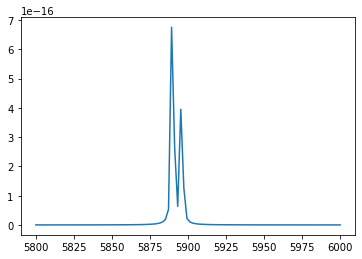

In [36]:
vs = np.linspace(1e4/5800, 1e4/6000, 100)
plt.plot(1e4/vs, c.linea(0, vs, 'NaD1') + c.linea(0, vs, 'NaD2'))

In [24]:
c.sigTot(0, 'NaD1')*2**0.5 

0.05278220125057454

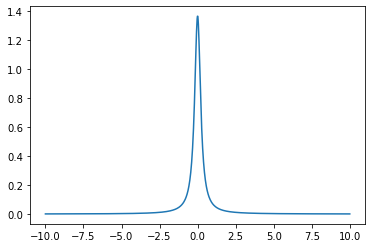

In [37]:
plt.plot(np.linspace(-10, 10, 1000), voigt(np.linspace(-10, 10, 1000), .0373, 6.8e9/sc.c))

In [32]:
voigt(np.linspace(-10, 10, 1000), .0373, 6.8e9)

array([4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
       4.68102774e-11, 4.68102774e-11, 4.68102774e-11, 4.68102774e-11,
      